In [1]:
import numpy as np
import scipy.optimize as OPT
import matplotlib.pyplot as plt
import scipy

In [2]:
def cox_loss(est_lam):
    li = 0
    lams = [est_lam[0]]*num_m + [est_lam[1]]*num_f
    fx_exp = np.exp(lams)
    for i in range(len(obs_flag)):
        if obs_flag[i] == True:
            tp_li = fx_exp[i] / fx_exp[survs>=survs[i]].sum()
            li += -np.log(tp_li)
    return li

In [131]:
def get_time(uni_ran, tp_h, tp_num):
    tp_surv = []
    tp_int = lambda x: integrate.quad(tp_h, 0, x)[0]
    tp_sf = lambda x: tp_int(x)+np.log(1-tp_r)
    tp_rs = np.random.uniform(size=tp_num)
    for tp_r in tp_rs:
        tp_surv.append(fsolve(tp_sf, x0=1)[0])
    return np.array(tp_surv)

In [5]:
from scipy import integrate
from scipy.optimize import fsolve

In [34]:
tp_hazard = lambda x: np.exp(1)
tp_num = 1000

tp_surv = []
tp_int = lambda x: integrate.quad(tp_hazard, 0, x)[0]
tp_sf = lambda x: tp_int(x)+np.log(1-tp_r)

tp_rs = np.random.uniform(size=num_m)
for tp_r in tp_rs:
    tp_surv.append(fsolve(tp_sf, x0=1)[0])

In [132]:
lam_m= 3
c_m = 5

lam_f = 1
c_f = 1

base_h = lambda x: 1
m_hazard = lambda x: base_h(x)*np.exp(lam_m)
f_hazard = lambda x: base_h(x)*np.exp(lam_f)

num_m = 1000
num_f = 4000

for i in range(1):
    m_suv = get_time(np.random.uniform(size=num_m), m_hazard, num_m)
    m_cen = np.random.exponential(scale=1/c_m, size=num_m)
    m_obs = (m_suv<=m_cen)
    m_suv[m_obs==False]=m_cen[m_obs==False]
    
    f_suv = get_time(np.random.uniform(size=num_f), f_hazard, num_f)
    f_cen = np.random.exponential(scale=1/c_f, size=num_f)
    f_obs = (f_suv<=f_cen)
    f_suv[f_obs==False]=f_cen[f_obs==False]

    survs = np.concatenate((m_suv, f_suv), axis=0)
    obs_flag = np.concatenate((m_obs, f_obs), axis=0)
    bnds = ((0, 20),)*2
    res = OPT.minimize(cox_loss, [5, 5], method='Powell', bounds=bnds, tol=1e-3)
    print(res.x)
    print(res.x[0] - res.x[1])
    print()

[7.02270421 5.00002919]
2.022675013476631



In [133]:
# estimation using breslow method
def Breslow(ts, obs, hs):
    est_ts = []
    est_bh = []
    for i in range(len(ts)):
        t = ts[i]
        if obs[i]:
            tp_dom = np.exp(hs[ts>=t]).sum()
            if len(est_ts) == 0:
                est_bh.append(1/tp_dom)
            else:
                est_bh.append(1/tp_dom+est_bh[-1])
            est_ts.append(t)
    return np.array(est_ts), np.array(est_bh)

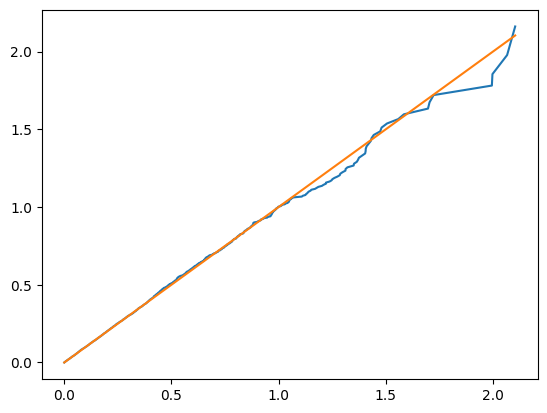

In [134]:
zipped = sorted(zip(survs, obs_flag, [lam_m]*num_m+[lam_f]*num_f), key=lambda x: x[0])
ts, obs, hs = [np.array([x[i] for x in zipped]) for i in range(3)]
xs, ys = Breslow(ts, obs, hs)
plt.plot(xs, ys)
plt.plot(xs, [integrate.quad(base_h, 0, x)[0] for x in xs])
# plt.xlim(0,1.5)
plt.show()